In [33]:
%load_ext autoreload
%autoreload 2

import os
import h5py
import time

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.33"

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import jax
import jax.numpy as jnp
import flax.linen as nn
from flax.training import orbax_utils
import optax
import orbax.checkpoint as ocp
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp

tfp = tfp.experimental.substrates.jax
tfb = tfp.bijectors
tfd = tfp.distributions

from numpyro import distributions as dist

from tqdm import tqdm
from functools import partial

from getdist import MCSamples, plots
import tarp

from jaxili.model import ConditionalMAF

from network import CNN2DCompressor, MAF_CNNCompressor
from loss import loss_nll_npe, loss_nll_nle, loss_mmd_npe, mmd_summary_space, maximum_mean_discrepancy
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#jax.config.update('jax_platform_name', 'cpu')
jax.devices()

[cuda(id=0)]

In [34]:
plt.rcParams.update({
    "axes.labelsize": 20,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 25,
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["times"],
    "text.latex.preamble": r"\usepackage{amsmath}"
})

# Model Mispecification in cosmology

The goal of this notebook is to assess the ability of MMD to detect model misspecification using weak lensing statistics.

### Creating the dataset

Let's first create a dataset obtained from the cosmogrid simulations.

In [4]:
#Configuration for the noise augmentation
sigma_e = 0.26
galaxy_density = 10/4
field_size = size = 10
field_npix = xsize = 80
nside = 512
reso = size * 60 / xsize
nbins = 1
dim = 6

In [84]:
#Get the fiducial cosmology
master_key = jax.random.PRNGKey(0) #Create a random seed

filename = "/home/sacha/Documents/cosmogrid/CosmoGridV1_metainfo.h5"
f = h5py.File(filename, 'r') #Recover informations on the cosmogrid simulations
dataset_grid = f["parameters"]["fiducial"]
cosmo_parameters = jnp.array(
    [
        dataset_grid["Om"],
        dataset_grid["s8"],
        dataset_grid["w0"],
        dataset_grid["H0"] / 100,
        dataset_grid["ns"],
        dataset_grid["Ob"]
    ]
).T
truth = list(cosmo_parameters[0])
path = "/home/sacha/Documents/cosmogrid/projected_probes_maps_baryonified512.h5"
m_data = h5py.File(path, "r")
m_data = np.array(m_data["kg"][f"stage3_lensing{4}"]) + np.array(m_data["ia"][f'stage3_lensing{4}'])
proj = hp.projector.GnomonicProj(rot=[0, 0, 0], xsize=xsize, ysize=xsize, reso=reso)
m_data = proj.projmap(m_data, vec2pix_func=partial(hp.vec2pix, nside))
path = "/home/sacha/Documents/cosmogrid/projected_probes_maps.h5"
m_data_mms = h5py.File(path, "r")
m_data_mms = np.array(m_data_mms["kg"][f"stage3_lensing{4}"]) #Turn off intrinsic alignment
m_data_mms = proj.projmap(m_data_mms, vec2pix_func=partial(hp.vec2pix, nside))

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/home/sacha/Documents/cosmogrid/projected_probes_maps.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

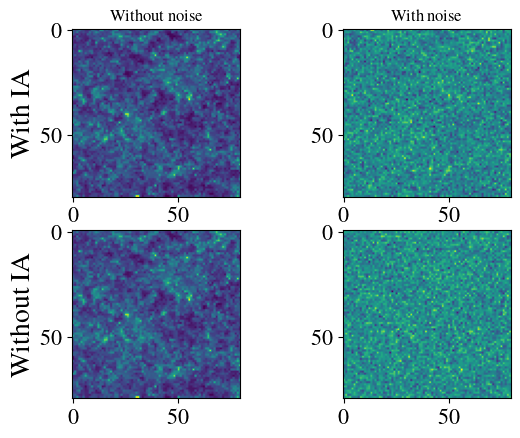

In [65]:
plt.figure()

plt.subplot(221)
plt.title("Without noise")
plt.imshow(m_data.squeeze())
plt.ylabel("With baryons and IA")

key, master_key = jax.random.split(master_key)
m_data_noise = dist.Independent(
    dist.Normal(
        m_data,
        sigma_e / jnp.sqrt(galaxy_density * (field_size*60/field_npix)**2),
    ),
    2,
).sample(key, (1,))

plt.subplot(222)
plt.title("With noise")
plt.imshow(m_data_noise.squeeze())

plt.subplot(223)

plt.imshow(m_data_mms.squeeze())
plt.ylabel("Without baryons and IA")

key, master_key = jax.random.split(master_key)
m_data_mms_noise = dist.Independent(
    dist.Normal(
        m_data_mms,
        2*sigma_e / jnp.sqrt(galaxy_density * (field_size*60/field_npix)**2),
    ),
    2,
).sample(key, (1,))

plt.subplot(224)

plt.imshow(m_data_mms_noise.squeeze())

plt.show()

In [7]:
params_name = [
    r"$\Omega_m$",
    r"$\sigma_8$",
    r"$w_0$",
    r"$h_0$",
    r"$n_s$",
    r"$\Omega_b$",
]

cosmo_labels_gd = [
    r'\Omega_m', r'\sigma_8', r'w_0', r'h', r'n_s', r'\Omega_b'
]

In [8]:
#Data loading and augmentation
def augmentation_noise(
    example, sigma_e=0.31, galaxy_density=7, field_size=10, field_npix=80
):
    x = example["map_nbody_w_baryon_ia"]
    x += tf.random.normal(
        shape=(field_npix, field_npix),
        stddev=sigma_e * jnp.sqrt(galaxy_density * (field_size*60/field_npix)**2)
    )
    return {"maps": x, "theta": example["theta"]}

def augmentation_flip(example):
    x = tf.expand_dims(example["maps"], 0)
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    return {"maps": x, "theta": example["theta"]}

def augmentation(example):
    return augmentation_flip(
        augmentation_noise(
            example,
            sigma_e=sigma_e,
            galaxy_density=galaxy_density,
            field_size=field_size,
            field_npix=field_npix
        ))

In [9]:
dim_params = dim
comp_dim = dim #Sufficient statistics

comp_hparams = {
    'output_dim': comp_dim,
    'activation': jax.nn.leaky_relu
}

nf_hparams = {
    'n_in': dim_params,
    'n_cond': comp_dim,
    'n_layers': 5,
    'layers': [128, 128],
    'activation': jax.nn.relu,
    'use_reverse': True,
    'seed': 42
}

#Create the model
nf_cnn_compressor = MAF_CNNCompressor(
    CNN2DCompressor,
    ConditionalMAF,
    comp_hparams,
    nf_hparams
)

key, master_key = jax.random.split(master_key)
params_nf_cnn = nf_cnn_compressor.init(key, m_data_noise, cosmo_parameters[0])

print(
    f'Number of parameters: {sum(x.size for x in jax.tree_util.tree_leaves(params_nf_cnn))}'
)

Number of parameters: 154082


In [10]:
#Define update function
def update(params, opt_state, x, theta, loss_fn, optimizer):
    loss, grad = jax.value_and_grad(loss_fn)(params, x, theta)
    updates, opt_state = optimizer.update(grad, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state, loss

update_jit = jax.jit(update, static_argnums=(4, 5))

#Define a function to create batches
def is_new_best_model(val_loss, best_model_loss):
    if best_model_loss is None:
        return True
    return val_loss < best_model_loss

#Define the training function
def training_loop(params, opt_state, epochs, train_set, test_set, loss_fn, generative_model, optimizer, master_key, checkpoint_path=None):

    #Create the checkpoint manager
    if checkpoint_path is not None:
        options = ocp.CheckpointManagerOptions(
            max_to_keep=1, create=True
        )
        orbax_checkpointer = ocp.PyTreeCheckpointer()
        checkpoint_manager = ocp.CheckpointManager(
            checkpoint_path, orbax_checkpointer, options
        )
    
    #Perform the training
    train_loss_tracker = []
    val_loss_tracker = []

    pbar = tqdm(range(1, epochs+1), desc="Epochs")
    best_model_loss = None

    start_time = time.time()
    for epoch in pbar:
        train_loader = iter(tfds.as_numpy(train_set))
        train_loss = 0
        num_train_steps = 0
        for batch in train_loader:
            x = batch["maps"]
            theta = batch["theta"]
            params, opt_state, loss = update_jit(params, opt_state, x, theta, loss_fn, optimizer)
            train_loss += loss
            num_train_steps += 1
        train_loss /= num_train_steps
        train_loss_tracker.append(train_loss)

        #Compute a validation loss
        test_loader = iter(tfds.as_numpy(test_set))
        val_loss = 0
        num_elements = 0
        for batch in test_loader:
            x = batch["maps"]
            theta = batch["theta"]
            batch_size = theta.shape[0]
            val_loss += loss_fn(params, x, theta) * batch_size
            num_elements += batch_size

        val_loss /= num_elements
        val_loss_tracker.append(val_loss)

        if is_new_best_model(val_loss, best_model_loss):
            best_model_loss = val_loss
            best_epoch = epoch

            if checkpoint_path is not None:
                save_args = orbax_utils.save_args_from_target(params)
                checkpoint_manager.save(epoch, params, save_kwargs={"save_args": save_args})

        pbar.set_description(f"Epochs (train/val/best): {train_loss:.2e}/{val_loss:.2e}/{best_model_loss:.2e}")
    end_time = time.time()
    print(f"Training done. Time take: {end_time - start_time:.2f}s")
    print(f"Best loss: {best_model_loss:.2e} at epoch {best_epoch}")

    if checkpoint_path is not None:
        print("Loading best model...")
        step = checkpoint_manager.latest_step()
        params = checkpoint_manager.restore(step)
        print("Best model loaded...")

    return params, opt_state, loss, train_loss_tracker, val_loss_tracker

In [11]:
#Load and augment the dataset

# Train set
ds_tr = tfds.load("CosmogridGridDataset/grid_maps", split="train")

ds_tr = ds_tr.shuffle(800)
ds_tr = ds_tr.map(augmentation)
ds_tr = ds_tr.batch(128)
ds_tr = ds_tr.prefetch(tf.data.experimental.AUTOTUNE)
ds_train = iter(tfds.as_numpy(ds_tr))

# Test set
ds_te = tfds.load("CosmogridGridDataset/grid_maps", split="test")

ds_te = ds_te.shuffle(200)
ds_te = ds_te.map(augmentation)
ds_te = ds_te.batch(128)
ds_te = ds_te.prefetch(tf.data.experimental.AUTOTUNE)
ds_test = iter(tfds.as_numpy(ds_te))

In [85]:
test = tfds.load("CosmogridGridDataset/grid_maps", split="train")

In [88]:
for example in test:
    print(example)

{'map_nbody': <tf.Tensor: shape=(80, 80), dtype=float32, numpy=
array([[0.06622172, 0.06049123, 0.05942143, ..., 0.05912748, 0.07437199,
        0.05841042],
       [0.05812327, 0.07219476, 0.05510543, ..., 0.06316938, 0.07275815,
        0.05318999],
       [0.0770686 , 0.06098976, 0.07184748, ..., 0.08344738, 0.0982847 ,
        0.08058377],
       ...,
       [0.04789721, 0.05554658, 0.06876308, ..., 0.06861115, 0.06904447,
        0.07280361],
       [0.04914873, 0.05716575, 0.06137707, ..., 0.08600895, 0.0767815 ,
        0.06892297],
       [0.05760727, 0.06582551, 0.05722141, ..., 0.08807885, 0.07423771,
        0.06979538]], dtype=float32)>, 'map_nbody_w_baryon_ia': <tf.Tensor: shape=(80, 80), dtype=float32, numpy=
array([[0.05356184, 0.04969174, 0.04698027, ..., 0.0451883 , 0.05956956,
        0.04624487],
       [0.0439711 , 0.05740511, 0.04205121, ..., 0.05126303, 0.05926064,
        0.03942683],
       [0.06213295, 0.04644276, 0.05870798, ..., 0.07055527, 0.08202223,
      

: 

In [13]:
#Configuration for the training
checkpoint_path = "/home/sacha/Documents/Research project/SBI_model_misspecification/cosmogrid/checkpoints"
epochs = 10
learning_rate = 5e-4
warmup = 0.1

lr_scheduler = optax.warmup_cosine_decay_schedule(
    init_value=1e-4,
    peak_value=learning_rate,
    end_value = 0.01*learning_rate,
    warmup_steps = warmup,
    decay_steps = int(epochs * ds_tr.cardinality().numpy() * 128 * 0.9)
)
optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adam(learning_rate=lr_scheduler)
)

opt_state = optimizer.init(params_nf_cnn)

In [14]:
compress = lambda params, x : nf_cnn_compressor.apply(params, x, method="compress")
nf = lambda params, theta, z : nf_cnn_compressor.apply(params, theta, z, method="log_prob_from_compressed")
loss_fn = lambda params, x, theta : loss_mmd_npe(compress, nf, params, (theta, x))

#Training loop
params_nf_cnn, opt_state, loss, train_loss_tracker, val_loss_tracker = training_loop(
    params_nf_cnn,
    opt_state, 
    epochs=epochs,
    train_set=ds_tr,
    test_set=ds_te,
    loss_fn=loss_fn,
    generative_model=nf_cnn_compressor,
    optimizer=optimizer,
    master_key=master_key,
    checkpoint_path=None
)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

2024-09-04 13:55:51.623991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-09-04 13:56:55.856106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epochs (train/val/best): -4.89e+00/-6.86e+00/-6.86e+00:  10%|█         | 1/10 [02:08<19:12, 128.07s/it]2024-09-04 13:57:33.046399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-09-04 13:58:25.640894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epochs (train/val/best): -6.61e+00/-6.98e+00/-6.98e+00:  20%|██        | 2/10 [03:37<14:04, 105.56s/it]2024-09-04 13:59:07.065821: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-09-04 14:00:31.818505: W

Training done. Time take: 1180.51s
Best loss: -7.20e+00 at epoch 10


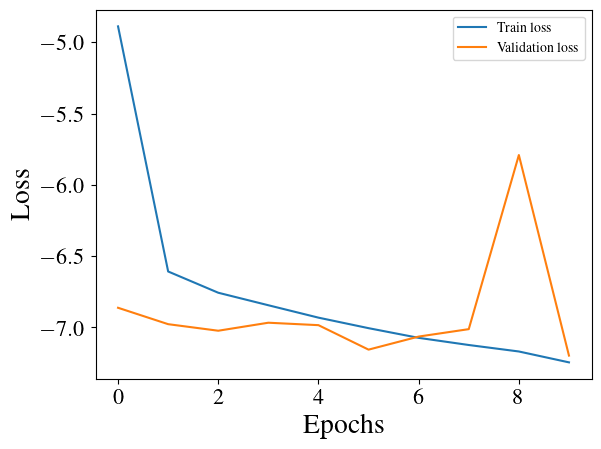

In [15]:
plt.figure()

plt.plot(train_loss_tracker, label="Train loss")
plt.plot(val_loss_tracker, label="Validation loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [16]:
ds_test = iter(tfds.as_numpy(ds_te))
batch = next(ds_test)
x, theta = batch["maps"], batch["theta"]

In [17]:
z_val = compress(params_nf_cnn, x)
key, master_key = jax.random.split(master_key)
mmd = mmd_summary_space(z_val, key)
log_prob = nf(params_nf_cnn, theta, z_val)

print(f"MMD: {mmd}")
print(f"Negative Log_Likelihood: {-jnp.mean(log_prob)}")
print(f"Loss: {-jnp.mean(log_prob) + mmd}")

MMD: 0.19748306274414062
Negative Log_Likelihood: -7.493660926818848
Loss: -7.296177864074707


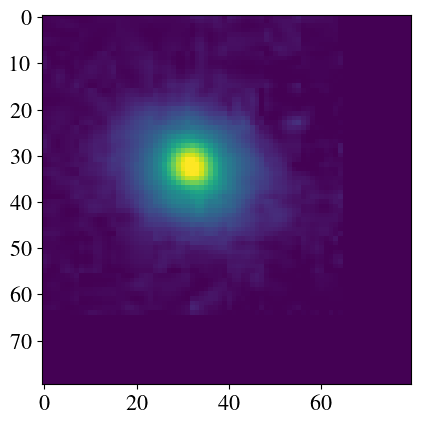

In [77]:
from PIL import Image

im = Image.open("/home/sacha/Documents/Thèse/ERC/euclid-school-2024/dataset/zoo-data/test/smooth/0001.jpg")
im = np.asarray(im)
new_im = np.zeros((80, 80))
new_im[:im.shape[0], :im.shape[1]] = im[:, :, 0]

plt.imshow(new_im)

Removed no burn in
Removed no burn in
MMD fiducial: 7.699918746948242
MMD Misspecified: 7.897617340087891


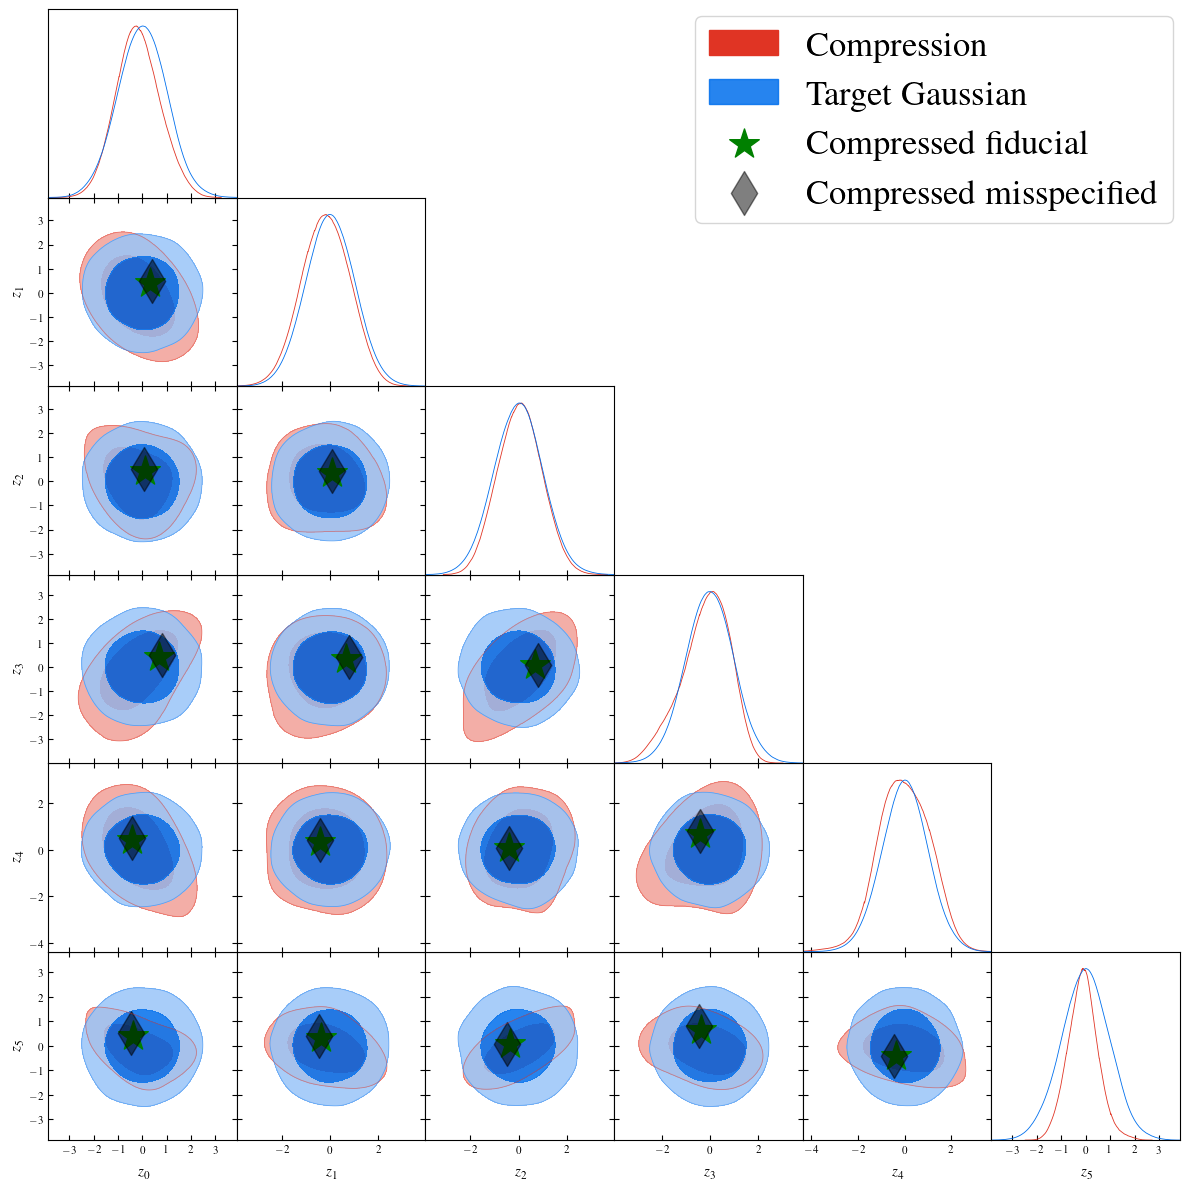

In [83]:
names = [f"z_{i}" for i in range(z_val.shape[1])]
labels = [f"z_{i}" for i in range(z_val.shape[1])]
samples_z = MCSamples(
    samples=z_val,
    names=names,
    labels=labels,
    label='Compression'
)

key, master_key = jax.random.split(master_key)
samples_gaussian = MCSamples(
    samples=jax.random.multivariate_normal(mean=jnp.zeros(dim), cov=jnp.eye(dim), key=key, shape=(10_000,)),
    names=names,
    labels=labels,
    label='Target Gaussian'
)

g = plots.get_subplot_plotter()
g.triangle_plot([samples_z, samples_gaussian], names, filled=True)

z_obs = compress(params_nf_cnn, m_data_noise)

mmd = maximum_mean_discrepancy(z_obs.reshape((1, -1)), z_val)

print(f"MMD fiducial: {mmd}")

z_mms = compress(params_nf_cnn, m_data_mms_noise)#new_im.reshape((1, 80, 80)))

mmd = maximum_mean_discrepancy(z_mms.reshape((1, -1)), z_val)

print(f"MMD Misspecified: {mmd}")

for i in range(dim):
    for j in range(dim):
        if i > j:
            ax = g.get_axes(ax=(i, j))
            obs_handle = ax.scatter([z_obs[i]], [z_obs[j]], s=500, color='g', marker='*', label='Compressed fiducial')
            mms_handle = ax.scatter([z_mms[i]], [z_mms[j]], s=500, color='k', marker='d', label='Compressed misspecified', alpha=0.5)
handles = g.fig.legends[0].legend_handles
handles.append(obs_handle)
handles.append(mms_handle)
labels = ['Compression', 'Target Gaussian', 'Compressed fiducial', 'Compressed misspecified']
g.fig.legends[0].remove()
g.fig.legend(handles, labels, loc='upper right')


plt.show()

In [79]:
z_mms

Array([ 161.32616 ,  148.30136 ,   29.028086,  203.62904 ,  -97.53331 ,
       -108.42481 ], dtype=float32)

In [62]:
z_val.shape

(128, 6)

### Assessing the performance of the normalizing flow

In [51]:
#Coverage plot using TARP
batch = next(ds_test)
x, theta = batch["maps"], batch["theta"]
nsamples = 10_000
samples = np.empty(shape=(0, nsamples, dim))
params = np.empty(shape=(0, dim))
for i in range(3):
    batch = next(ds_test)
    x, theta = batch["maps"], batch["theta"]
    for data_x, data_theta in tqdm(zip(x, theta)):
        params = np.vstack([params, data_theta])
        key, master_key = jax.random.split(master_key)
        new_samples = nf_cnn_compressor.apply(params_nf_cnn, key, data_x, n_samples=nsamples, method="sample")
        new_samples = np.array(new_samples).reshape((1, -1, dim))
        samples = np.vstack([samples, new_samples])
samples = samples.reshape((nsamples, -1, dim))

128it [01:15,  1.69it/s]
128it [01:19,  1.60it/s]
128it [01:26,  1.49it/s]


In [52]:
tarp_ = tarp.get_tarp_coverage(samples, params, bootstrap=True)

100%|██████████| 100/100 [00:42<00:00,  2.37it/s]


In [53]:
tarp_low, tarp_mid_low, tarp_mid, tarp_mid_up, tarp_up = np.percentile(tarp_[0], q=[2.5, 16, 50, 84, 98.5], axis=0)

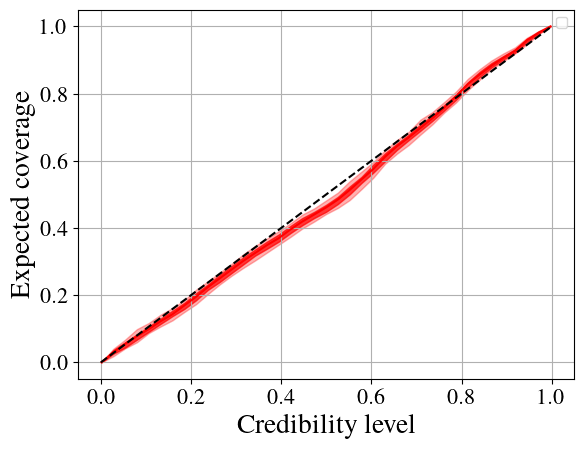

In [55]:
plt.figure()

plt.plot(tarp_[1], tarp_mid, color='red')
plt.fill_between(tarp_[1], tarp_mid_low, tarp_mid_up, color='red', alpha=0.7)
plt.fill_between(tarp_[1], tarp_low, tarp_up, color='red', alpha=0.3)
alpha = np.linspace(0, 1, num=100)
plt.plot(alpha, alpha, ls='--', c='k')
plt.legend()
plt.xlabel("Credibility level")
plt.ylabel("Expected coverage")
plt.grid()

plt.show()


In [75]:
#Coverage plot for Omega_m and sigma_8
batch = next(ds_test)
x, theta = batch["maps"], batch["theta"]

Omega_m_err = []
Omega_m = []
sigma_8 = []
sigma_8_err = []

for data_x, data_theta in tqdm(zip(x, theta)):
    key, master_key = jax.random.split(master_key)
    new_samples = nf_cnn_compressor.apply(params_nf_cnn, key, data_x, n_samples=nsamples, method="sample")
    estim_param = np.percentile(new_samples, q=50, axis=0)
    estim_param_err = np.std(new_samples, axis=0)
    Omega_m.append(estim_param[0])
    Omega_m_err.append(estim_param_err[0])
    sigma_8.append(estim_param[1])
    sigma_8_err.append(estim_param_err[1])

128it [01:27,  1.46it/s]


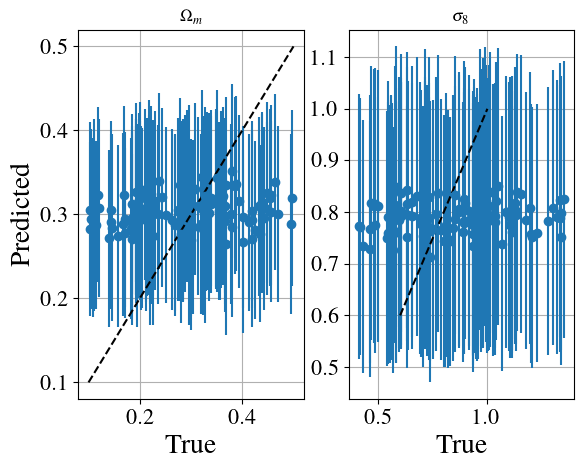

In [76]:
plt.figure()

plt.subplot(121)

plt.title(r"$\Omega_m$")

x = np.linspace(0.1, 0.5, num=100)
plt.errorbar(theta[:, 0], Omega_m, yerr=Omega_m_err, fmt='o')
plt.plot(x, x, ls='--', c='k')

plt.xlabel("True")
plt.ylabel("Predicted")

plt.grid()

plt.subplot(122)

plt.title(r"$\sigma_8$")

x = np.linspace(0.6, 1.0, num=100)
plt.errorbar(theta[:, 1], sigma_8, yerr=sigma_8_err, fmt='o')
plt.plot(x, x, ls='--', c='k')
plt.xlabel("True")

plt.grid()
plt.show()


### Posterior check on the fiducial simulation

In [63]:
key, master_key = jax.random.split(master_key)
samples_fiducial = nf_cnn_compressor.apply(params_nf_cnn, key, m_data_noise, n_samples=10_000, method="sample")

Removed no burn in


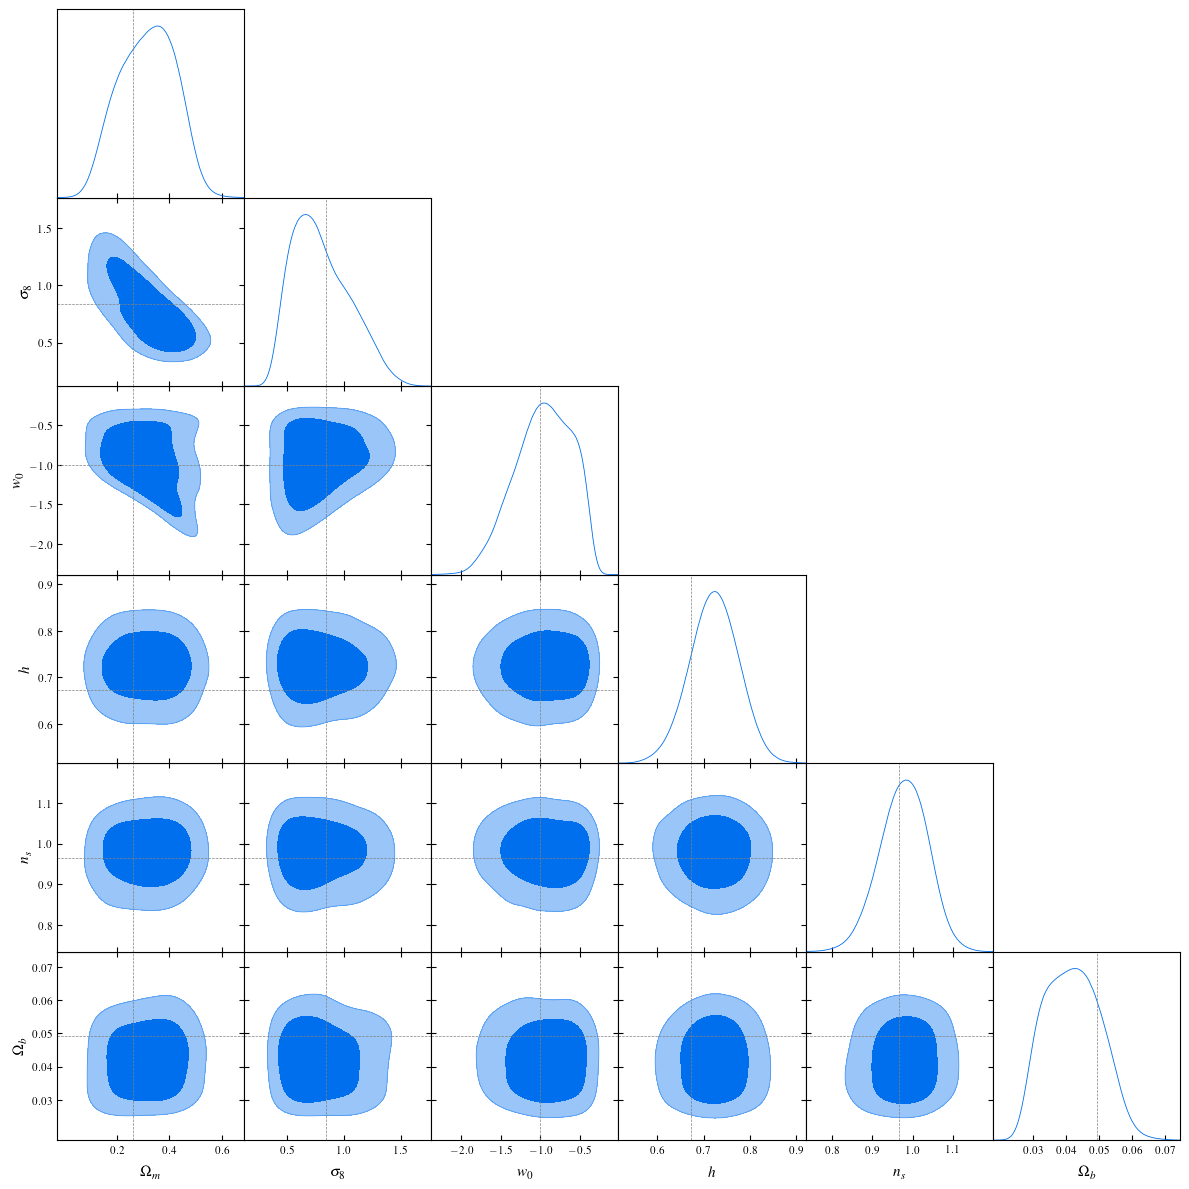

In [71]:
samples_fid_gd = MCSamples(
    samples = samples_fiducial,
    names = cosmo_labels_gd,
    labels = cosmo_labels_gd
)

g = plots.get_subplot_plotter()
g.triangle_plot(samples_fid_gd, cosmo_labels_gd, filled=True,
markers={
                    label: val for label, val in zip(cosmo_labels_gd, truth)   
               })

plt.show()

### Comparison to what would be obtained with the package sbi